In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.8
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 7s 789ms/step - loss: 0.0030
Average validation loss: 0.5863011479377747
4/4 [==============================] - 7s 803ms/step - loss: 0.0030 - val_loss: 0.5863
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 10s 707ms/step - loss: 0.0019 - val_loss: 0.5863
Average validation loss: 0.602914571762085
4/4 [==============================] - 10s 717ms/step - loss: 0.0019 - val_loss: 0.5946
Epoch 3/10
4/4 [==============================] - 13s 723ms/step - loss: 0.0014 - val_loss: 0.5946
Average validation loss: 0.5908817052841187
4/4 [==============================] - 13s 731ms/step - loss: 0.0014 - val_loss: 0.5934
Epoch 4/10
4/4 [==============================] - 16s 716ms/step - loss: 0.0011 - val_loss: 0.5934
Average validation loss: 0.5828474164009094
4/4 [=================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 7s 884ms/step - loss: 6.9268e-07
Average validation loss: 0.0028390943771228194
8/8 [==============================] - 7s 898ms/step - loss: 6.9268e-07 - val_loss: 0.0028
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 14s 830ms/step - loss: 6.9516e-07 - val_loss: 0.0028
Average validation loss: 0.00401120656169951
8/8 [==============================] - 14s 844ms/step - loss: 6.9516e-07 - val_loss: 0.0034
Epoch 3/10
8/8 [==============================] - 21s 832ms/step - loss: 6.8617e-07 - val_loss: 0.0034
Average validation loss: 0.025693044066429138
8/8 [==============================] - 21s 848ms/step - loss: 6.8617e-07 - val_loss: 0.0108
Epoch 4/10
8/8 [==============================] - 28s 867ms/step - loss: 6.8664e-07 - val_loss: 0.0108
Average validation loss: 0.024

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 738ms/step - loss: 1.5334e-06
Average validation loss: 0.029223413361857336
12/12 [==============================] - 9s 750ms/step - loss: 1.5334e-06 - val_loss: 0.0292
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 724ms/step - loss: 1.5287e-06 - val_loss: 0.0292
Average validation loss: 0.028734578983858228
12/12 [==============================] - 18s 735ms/step - loss: 1.5287e-06 - val_loss: 0.0290
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 27s 751ms/step - loss: 1.5404e-06 - val_loss: 0.0290
Average validation loss: 0.038277219980955124
12/12 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 749ms/step - loss: 1.4801e-06
Average validation loss: 0.07176539953798056
16/16 [==============================] - 12s 759ms/step - loss: 1.4801e-06 - val_loss: 0.0718
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 24s 731ms/step - loss: 1.4374e-06 - val_loss: 0.0718
Average validation loss: 0.05142014008015394
16/16 [==============================] - 24s 742ms/step - loss: 1.4374e-06 - val_loss: 0.0616
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 36s 747ms/step - loss: 1.3722e-06 - val_loss: 0.0616
Average validation loss: 0.049425633158534765
16/16 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 686ms/step - loss: 5.8190e-07
Average validation loss: 0.09030992463231087
20/20 [==============================] - 14s 697ms/step - loss: 5.8190e-07 - val_loss: 0.0903
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 28s 680ms/step - loss: 5.6649e-07 - val_loss: 0.0903
Average validation loss: 0.10228550732135773
20/20 [==============================] - 28s 690ms/step - loss: 5.6649e-07 - val_loss: 0.0963
Epoch 3/10
20/20 [==============================] - 42s 686ms/step - loss: 5.6182e-07 - val_loss: 0.0963
Average validation loss: 0.09632734581828117
20/20 [==============================] - 42s 697ms/step - loss: 5.6182e-07 - val_loss: 0.0963
Epoch 4/10
20/20 [==============================] - 55s 680ms/step - loss: 5.4762e-07 - val_loss: 0.0963
Average validatio

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 16s 682ms/step - loss: 5.2807e-07
Average validation loss: 0.09930646046996117
24/24 [==============================] - 17s 692ms/step - loss: 5.2807e-07 - val_loss: 0.0993
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 33s 680ms/step - loss: 5.4580e-07 - val_loss: 0.0993
Average validation loss: 0.09193457911411922
24/24 [==============================] - 33s 689ms/step - loss: 5.4580e-07 - val_loss: 0.0956
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 50s 681ms/step - loss: 5.2032e-07 - val_loss: 0.0956
Average validation loss: 0.08012859895825386
24/24 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 27s 672ms/step - loss: 1.1612e-06
Average validation loss: 0.0714607860893011
40/40 [==============================] - 27s 682ms/step - loss: 1.1612e-06 - val_loss: 0.0715
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 54s 673ms/step - loss: 9.5651e-07 - val_loss: 0.0715
Average validation loss: 0.11659589484333992
40/40 [==============================] - 55s 683ms/step - loss: 9.5651e-07 - val_loss: 0.0940
Epoch 3/10
40/40 [==============================] - 82s 681ms/step - loss: 8.3562e-07 - val_loss: 0.0940
Average validation loss: 0.11497413963079453
40/40 [==============================] - 82s 691ms/step - loss: 8.3562e-07 - val_loss: 0.1010
Epoch 4/10
40/40 [==============================] - 109s 670ms/step - loss: 7.5808e-07 - val_loss: 0.1010
Average validatio

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 33s 694ms/step - loss: 4.5086e-07
Average validation loss: 0.07362248469144106
48/48 [==============================] - 34s 705ms/step - loss: 4.5086e-07 - val_loss: 0.0736
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 67s 690ms/step - loss: 3.4558e-07 - val_loss: 0.0736
Average validation loss: 0.04955676355166361
48/48 [==============================] - 67s 700ms/step - loss: 3.4558e-07 - val_loss: 0.0616
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 101s 705ms/step - loss: 2.8652e-07 - val_loss: 0.0616
Average validation loss: 0.051047764640922345
48/48 [==============================]

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 39s 697ms/step - loss: 6.3605e-07
Average validation loss: 0.07093533038693879
56/56 [==============================] - 40s 707ms/step - loss: 6.3605e-07 - val_loss: 0.0709
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 79s 698ms/step - loss: 4.3593e-07 - val_loss: 0.0709
Average validation loss: 0.07245907257311046
56/56 [==============================] - 79s 709ms/step - loss: 4.3593e-07 - val_loss: 0.0717
Epoch 3/10
56/56 [==============================] - 119s 709ms/step - loss: 3.4378e-07 - val_loss: 0.0717
Average validation loss: 0.07226731421958123
56/56 [==============================] - 120s 719ms/step - loss: 3.4378e-07 - val_loss: 0.0719
Epoch 4/10
56/56 [==============================] - 159s 701ms/step - loss: 2.9058e-07 - val_loss: 0.0719
Average valida

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 44s 694ms/step - loss: 1.2649e-06
Average validation loss: 0.08761586726177484
64/64 [==============================] - 45s 704ms/step - loss: 1.2649e-06 - val_loss: 0.0876
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 89s 688ms/step - loss: 1.1537e-06 - val_loss: 0.0876
Average validation loss: 0.05728514620568603
64/64 [==============================] - 90s 697ms/step - loss: 1.1537e-06 - val_loss: 0.0725
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 133s 683ms/step - loss: 9.7606e-07 - val_loss: 0.0725
Average validation loss: 0.07031749145244248
64/64 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 51s 701ms/step - loss: 4.3878e-07
Average validation loss: 0.05441767474015554
72/72 [==============================] - 51s 711ms/step - loss: 4.3878e-07 - val_loss: 0.0544
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 101s 696ms/step - loss: 3.0159e-07 - val_loss: 0.0544
Average validation loss: 0.05973054841160774
72/72 [==============================] - 102s 705ms/step - loss: 3.0159e-07 - val_loss: 0.0571
Epoch 3/10
72/72 [==============================] - 152s 696ms/step - loss: 2.2855e-07 - val_loss: 0.0571
Average validation loss: 0.05916973017156124
72/72 [==============================] - 153s 706ms/step - loss: 2.2855e-07 - val_loss: 0.0578
Epoch 4/10
72/72 [==============================] - 203s 698ms/step - loss: 1.8951e-07 - val_loss: 0.0578
Average vali

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 56s 706ms/step - loss: 3.2732e-07
Average validation loss: 0.061335367243736984
80/80 [==============================] - 57s 716ms/step - loss: 3.2732e-07 - val_loss: 0.0613
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 114s 710ms/step - loss: 2.4845e-07 - val_loss: 0.0613
Average validation loss: 0.062190530262887476
80/80 [==============================] - 115s 720ms/step - loss: 2.4845e-07 - val_loss: 0.0618
Epoch 3/10
80/80 [==============================] - 171s 695ms/step - loss: 1.9283e-07 - val_loss: 0.0618
Average validation loss: 0.0625750775448978
80/80 [==============================] - 171s 705ms/step - loss: 1.9283e-07 - val_loss: 0.0620
Epoch 4/10
80/80 [==============================] - 227s 699ms/step - loss: 1.6067e-07 - val_loss: 0.0620
Average va

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 67s 699ms/step - loss: 7.5406e-07
Average validation loss: 0.09795659652445465
96/96 [==============================] - 68s 709ms/step - loss: 7.5406e-07 - val_loss: 0.0980
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 135s 701ms/step - loss: 4.7347e-07 - val_loss: 0.0980
Average validation loss: 0.08575852514089395
96/96 [==============================] - 136s 712ms/step - loss: 4.7347e-07 - val_loss: 0.0919
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 204s 700ms/step - loss: 3.6016e-07 - val_loss: 0.0919
Average validation loss: 0.0909358955686912
96/96 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 84s 703ms/step - loss: 3.7279e-07
Average validation loss: 0.06158714876510203
120/120 [==============================] - 85s 712ms/step - loss: 3.7279e-07 - val_loss: 0.0616
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 170s 703ms/step - loss: 2.6445e-07 - val_loss: 0.0616
Average validation loss: 0.05320231056927393
120/120 [==============================] - 171s 713ms/step - loss: 2.6445e-07 - val_loss: 0.0574
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 256s 706ms/step - loss: 2.0591e-07 - val_loss: 0.0574
Average validation loss: 0.05877893889167656
120/120 [================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 102s 709ms/step - loss: 3.0275e-07
Average validation loss: 0.04609100391260452
144/144 [==============================] - 104s 719ms/step - loss: 3.0275e-07 - val_loss: 0.0461
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 204s 699ms/step - loss: 2.0565e-07 - val_loss: 0.0461
Average validation loss: 0.04894689502220394
144/144 [==============================] - 206s 709ms/step - loss: 2.0565e-07 - val_loss: 0.0475
Epoch 3/10
144/144 [==============================] - 307s 700ms/step - loss: 1.6288e-07 - val_loss: 0.0475
Average validation loss: 0.04903721609540904
144/144 [==============================] - 308s 709ms/step - loss: 1.6288e-07 - val_loss: 0.0480
Epoch 4/10
144/144 [==============================] - 409s 705ms/step - loss: 1.3623e-07 - val_loss: 0.

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 114s 712ms/step - loss: 2.7357e-07
Average validation loss: 0.0938313760503661
160/160 [==============================] - 115s 722ms/step - loss: 2.7357e-07 - val_loss: 0.0938
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 228s 706ms/step - loss: 1.9765e-07 - val_loss: 0.0938
Average validation loss: 0.08201923107262701
160/160 [==============================] - 230s 716ms/step - loss: 1.9765e-07 - val_loss: 0.0879
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 344s 710ms/step - loss: 1.5954e-07 - val_loss: 0.0879
Average validation loss: 0.06899359285016544
160/160 [===============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 142s 708ms/step - loss: 5.2202e-07
Average validation loss: 0.053953752517700196
200/200 [==============================] - 144s 719ms/step - loss: 5.2202e-07 - val_loss: 0.0540
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 284s 702ms/step - loss: 3.4153e-07 - val_loss: 0.0540
Average validation loss: 0.0622783137485385
200/200 [==============================] - 286s 712ms/step - loss: 3.4153e-07 - val_loss: 0.0581
Epoch 3/10
200/200 [==============================] - 427s 705ms/step - loss: 2.5832e-07 - val_loss: 0.0581
Average validation loss: 0.0572850355412811
200/200 [==============================] - 429s 715ms/step - loss: 2.5832e-07 - val_loss: 0.0578
Epoch 4/10
200/200 [==============================] - 570s 703ms/step - loss: 2.1203e-07 - val_loss: 0.0

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:43 - loss: 3.4016e-08

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 169s 704ms/step - loss: 3.5369e-07
Average validation loss: 0.08433388614988264
240/240 [==============================] - 171s 714ms/step - loss: 3.5369e-07 - val_loss: 0.0843
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 340s 701ms/step - loss: 2.2945e-07 - val_loss: 0.0843
Average validation loss: 0.061823129215432954
240/240 [==============================] - 342s 711ms/step - loss: 2.2945e-07 - val_loss: 0.0731
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_80\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 512s 710ms/step - loss: 1.7687e-07 - val_loss: 0.0731
Average validation loss: 0.06856726219023888
240/240 [=============

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.17527940216474236, 0.041060846191248855, 0.07219369359624883, 0.0752643707965035, 0.08266379608400166, 0.08438268180005253, 0.09817510011512785, 0.06547826459437299, 0.07310026278719306, 0.06282147885067388, 0.0505744098403698, 0.0455360800337512, 0.06153330034780084, 0.04841049207064013, 0.05251820915368928, 0.0490195945049636, 0.05744789038999007, 0.04453324569104976]
std_val_losses =  [0.2043579706700109, 0.025551968612363394, 0.03619756190006573, 0.021184131131683354, 0.014507128965365941, 0.021610459488281872, 0.02671806773961107, 0.013027544729812867, 0.02233412701630434, 0.01175055675796899, 0.01032127339959195, 0.007950043847866755, 0.018602609964306623, 0.00958212313368735, 0.011726394995330658, 0.012804724738315032, 0.010392764258278361, 0.012455410523819889]


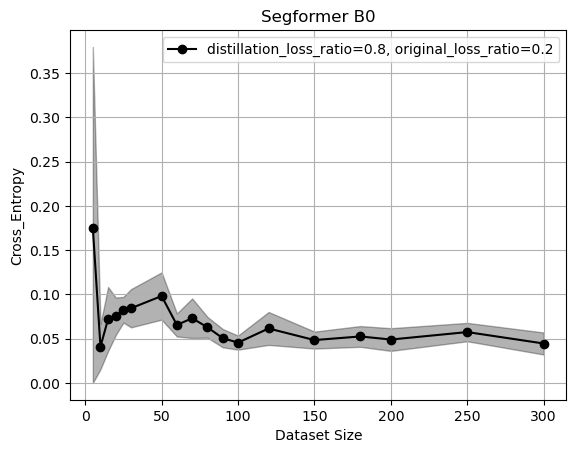

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()